# NLP Coursework Task 1 Approach 1 - BERT based Models





#0 README 
This Colab Notebook performs approach 1 for the task 1 on regression. There is another Colab Notebook for approach 2 and this can be found in the git repository https://github.com/rampopat/humour-reg . 

For clarity I have split this notebook into 16 labelled sections, each section starts with a brief explanation of what the section does.

**To reproduce Approach 1 report results**: There are 6 variants listed in the report Table 1:

1. BERT
2. BERT Ensemble
3. BERT + Preprocessing using CleanText and Ekphrasis
4. BERT + training on Funlines Dataset
5. RoBERTa
6. ALBERT

- Results 1,2,5,6, in the list above, can be obtained by **running the whole notebook sections 1-16 inclusive sequentially**. And specifically results 1,2,5,6 will be found in notebook sections 11,12,13,16 respectively. 
- Result 3 in the list above can be obtained by respectvely changing the flag  ```USE_PREPROCESSING``` to be True in Section 4 Configure Model Variants **and rerunning all the cells in sections 4-11 inclusive**.
- Result 4 in the list above can be obtained by respectvely changing the flag  ```USE_FUNLINES``` to be True in Section 4 Configure Model Variants **and rerunning all the cells in sections 4-11 inclusive**.

- **RoBERTa visualisation** using the Bert-viz library, which was discussed at the end of section 4.1 in the report, can be found in Section 15 of the notebook entitled 'Visualisation'.

- The value of the max length parameter for the BERT tokenizers was quoted in the report as 75, section 10 has the code to give this result(assumes no funlines data).

- Figures 2 and 3 which relate to the best model of Approach 1 i.e. RoBERTa's predictions (compared with Approach 2's best model) on the test set are displayed in the other notebook by using a csv file ```task-1-roberta.csv``` in the git repo, and so are not found in this notebook.

**Note: You can see that the results I have written in the report match the values in the output cells of this notebook. However, these were not obtained with a KNOWN random seed that is set at the start of each section 11-16, and since the results are sensitive to random seeds, you may get a worse result on rerunning a cell to the output displayed there.**

Note: in many places I have commented calls to ```save_model``` and ```load_model```. These would only work if you mounted your drive, but **I have made it so that you do not have to mount your drive**.

Finally, note that I tested the notebook on Colab with GPU, I recommend you do the same, as I have not tried with CPU only because these models are too slow there.



# 1 Get Data from Git Repo

You do not need to provide the dataset, it is downloaded swiftly from the git repository humour-reg and the data will be cloned into a folder called humour-reg hence the value of the ```PATH_TO_DATA``` variable.

In [1]:
!git clone https://github.com/rampopat/humour-reg
print('Contents of git repo are the following files:')
!ls humour-reg
PATH_TO_DATA = 'humour-reg/'
# PATH_TO_SAVED_MODELS = 'drive/MyDrive/NLPCoursework/BERTModels/'

Cloning into 'humour-reg'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 31 (delta 9), reused 5 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), done.
Contents of git repo are the following files:
competition.png  task_1_approach_2.ipynb  test.csv
dev.csv		 task-1-humournet.csv	  train.csv
README.md	 task-1-roberta.csv	  train_funlines.csv


In [18]:
# Mount drive for saving trained models
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


# 2 Installing Packages and Set Imports

This section installs all the necessary libraries for the subsequent sections.

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import re
import time
from sklearn.metrics import mean_squared_error

In [3]:
# For BERT Model
!pip install transformers
!pip install sentencepiece
import transformers
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import AlbertTokenizer, AlbertForSequenceClassification

     |████████████████████████████████| 1.9MB 7.5MB/s 
     |████████████████████████████████| 890kB 34.2MB/s 
     |████████████████████████████████| 3.2MB 54.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=ad389062d9e538a1e343686b5ec2826fd481478b1082356120f0a10435c4a97c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 1.2MB 8.3MB/s 


In [4]:
# For Preprocessing
!pip install ekphrasis
!pip install cleantext
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
import cleantext
import nltk
import string

     |████████████████████████████████| 81kB 5.1MB/s 
     |████████████████████████████████| 184kB 11.9MB/s 
     |████████████████████████████████| 71kB 7.5MB/s 
  Created wheel for ekphrasis: filename=ekphrasis-0.5.1-cp37-none-any.whl size=82844 sha256=671eda5bfc5094619d658a75d46e3ddc113f8bdcf38dd58aac954453cfc8fc26
  Stored in directory: /root/.cache/pip/wheels/2f/c5/9b/c9b60f535a2cf9fdbc92d84c4801a010c35a9cd348011ed2a1
  Created wheel for ftfy: filename=ftfy-5.9-cp37-none-any.whl size=46451 sha256=a98bc0bb2d81590b02d1aaa212df3d8a7ee6d0e4629d6522e9783244926516c3
  Stored in directory: /root/.cache/pip/wheels/5e/2e/f0/b07196e8c929114998f0316894a61c752b63bfa3fdd50d2fc3
Successfully built ekphrasis ftfy


In [5]:
# For BERT Visualisation
!pip install bertviz
from bertviz import head_view

     |████████████████████████████████| 163kB 9.2MB/s 
     |████████████████████████████████| 133kB 14.7MB/s 
     |████████████████████████████████| 71kB 8.1MB/s 
     |████████████████████████████████| 7.3MB 13.3MB/s 
ERROR: botocore 1.20.19 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


# 3 Setting Random Seed and Get Device

This sets seeds and returns device which should be GPU

In [7]:
# Setting random seed and device
def get_device_and_set_seed(seed):
    """ Set all seeds to make results reproducible """
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")
    return device
    
SEED = 1
device = get_device_and_set_seed(SEED)

# 4 Configure Model Variants

Change these to run the models under different settings. I recommend you leave them as is for the first running as unchanged these will give the majority of the results in Table 1 of the report. **Refer to the README in section 0 for further details**.

In [6]:
USE_FUNLINES = False
USE_PREPROCESSING = False

# 5 Load Data into Pandas DataFrames

During the hyperparameter tuning stage, our train loader consisted of just train.csv dataset and we used the dev.csv as our validation. Now, for our final models and report results, we **retrained on the combined train + valid sets and used the test data to evaluate the models**.

If you set the ```USE_FUNLINES``` flag, the funlines data will also be added to the train_df. 

In [8]:
# Load data
train_og_df = pd.read_csv(PATH_TO_DATA + 'train.csv')
train_funlines_df = pd.read_csv(PATH_TO_DATA + 'train_funlines.csv')
valid_df = pd.read_csv(PATH_TO_DATA + 'dev.csv')
# We concat train_og and valid because we are performing final testing here
if USE_FUNLINES:
    train_df = pd.concat([train_og_df, train_funlines_df, valid_df], ignore_index=True)
else:
    train_df = pd.concat([train_og_df, valid_df], ignore_index=True)
train_df = train_df.reset_index(drop=True)
test_df = pd.read_csv(PATH_TO_DATA + 'test.csv')
all_df = pd.concat([train_df, valid_df, test_df], ignore_index=True)

# 6 Preprocessing

Here we perform additional preprocessing from the CleanText and Ekphrasis libraries. I have commented to show what these libraries are doing and also showed a before and after output to see more clearly what they do.

See https://pypi.org/project/cleantext/ and https://github.com/cbaziotis/ekphrasis for further details.

In [9]:
nltk.download('stopwords')

# TextPreProcessor from ekphrasis library
text_processor = TextPreProcessor(    
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'], # terms to be normalized    
    annotate={"hashtag", "allcaps", "elongated", "repeated",
        'emphasis', 'censored'}, # terms to be annotated
    fix_html=True, 
    segmenter="twitter", # corpus used for word segmentation statistics
    corrector="twitter", # corpus used for spell correction statistics 
    unpack_hashtags=True,  # use word segmentation on hashtags
    unpack_contractions=True,  # expand contractions
    spell_correct_elong=True,  # spell correction  
    tokenizer=SocialTokenizer(lowercase=True).tokenize, # tokenizer
    dicts=[emoticons] # dictionary to replace tokens with other expressions
)

def preprocess(row):
    first_step = " ".join(text_processor.pre_process_doc(row))
    # Preprocessor from cleantext library
    cleaned = cleantext.clean_words(first_step,
        all= False, # Execute all cleaning operations
        extra_spaces=True, # Remove extra white space 
        stemming=False, # Stem the words
        stopwords=True, # Remove stop words
        lowercase=True, # Convert to lowercase
        numbers=True, # Remove all digits 
        punct=True, # Remove all punctuations
        stp_lang='english'  # Language for stop words
    )
    second_step = " ".join(cleaned)
    return second_step

# Show example of before and after preprocessing applied to entire train_df
print('Before Preprocessing')
print(train_df['original'])
print('After Preprocessing')
print(train_df['original'].apply(lambda row: preprocess(row)))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Word statistics files not found!
Downloading... 

/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt


/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading twitter - 1grams ...
Before Preprocessing
0        France is ‘ hunting down its citizens who join...
1        Pentagon claims 2,000 % increase in Russian tr...
2        Iceland PM Calls Snap Vote as Pedophile Furor ...
3        In an apparent first , Iran and Israel <engage...
4        Trump was told weeks ago that Flynn misled <Vi...
                               ...                        
12066    Supreme <Court/> Once Again Strikes Down Racia...
12067    Trump Mocks Schumer ’s Tears ; Vows to ‘ Make ...
12068    US government memo on the <danger/> of leaking...
12069    Newt Gingrich : Join Me in Supporting Judge Ro...
12070    In Search of Donald Trump at His Boyhood <Home/> 
Name: original, Length: 12071, dtype: object
After Preprocessing
0        france ‘ hunting citizens joined isis ’ withou...
1        pentagon claims number increase russian trolls...
2        iceland pm calls snap vote pedophile furor cra...
3             apparent first iran israel engage militarily


In [11]:
# Individual example of preprocessing, note that we perform this after 
# generating the edited headline later so it doesn't matter that the < /> is 
# removed
sample_headline = train_df['original'][100]
print(sample_headline)
print(preprocess(sample_headline))

Trump asked Duterte if Philippines has death <penalty/> , Philippines ambassador says
trump asked duterte philippines death penalty philippines ambassador says


# 7 Dataset Class

The Task1Dataset class has a few important features:
- ```get_headline_pair``` method takes an input headline with the word to be replaced enclosed in brackets e.g. 'my headline is <hello\> world' and an edit word e.g. 'goodbye' and returns 2 headlines: 1) the input headline without < /> i.e. 'my headline is hello world' and 2) the edited headline i.e. 'my headline is goodbye world' with the edit word.
- Its attributes include the dataframe it operates on ```df```, the ```max_len``` parameter that is used by the tokenizer to determine how many tokens each headline should be (after sufficient padding) and the ```tokenizer``` which is BERT-model specific. 
- The ```__get_item__``` method gets the row of the dataframe as the input ```index``` and extracts the two headlines using the ```get_headline_pair``` method, optionally preprocesses them depending on variants in Section 4, and tokenizes each headline by passing them in as a pair. It then returns 4 inputs required for the Huggingface BERT-based models: the ```input_ids``` (token ids of the tokens according to the BERT-based model), the ```token_type_ids``` (which sentence the tokens are in), the ```attention_mask``` (what's padding and what isn't), and the ```grade``` = the meangrade of the headline. 



In [10]:
class Task1Dataset(Dataset):
    def __init__(self, df, tokenizer, max_len=50):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.df)

    @staticmethod
    def get_headline_pair(headline_orig_brace, edit):
        headline_orig = re.sub('[</>]', '', headline_orig_brace)
        headline_edit = (headline_orig_brace.split("<"))[0] + edit + (headline_orig_brace.split(">"))[1]
        return headline_orig, headline_edit

    def __getitem__(self, index):
        headline_orig, headline_edit = self.get_headline_pair(self.df["original"][index], self.df["edit"][index])

        # Preprocess headlines - cannot do this before get_headline_pair because < /> will be removed
        if USE_PREPROCESSING:
            headline_orig = preprocess(headline_orig)
            headline_edit = preprocess(headline_edit)

        tokenize_dict = self.tokenizer(text=headline_orig, text_pair=headline_edit, add_special_tokens=True,
                                       padding='max_length', truncation=True, max_length=self.max_len,
                                       return_tensors='pt', return_token_type_ids=True, return_attention_mask=True)

        input_ids, token_type_ids, attention_mask = tokenize_dict['input_ids'], tokenize_dict['token_type_ids'], \
                                                    tokenize_dict['attention_mask']

        grade = torch.tensor(self.df["meanGrade"][index], dtype=torch.float)

        return input_ids.squeeze(), token_type_ids.squeeze(), attention_mask.squeeze(), grade

# 8 train, eval and model_performance functions

These 3 functions are key to train and evaluate the model. They have been modified to suit the BERT-based models. Note that the output of the train function has been truncated slightly because the loss is the MSE so there was no point printing that twice. ```model_performance``` was changed to output the RMSE too.```eval``` optionally outputs/prints the RMSE with its additional arguments. 

In [12]:
# How we print the model performance
def model_performance(output, target, print_output=False):
    """
    Returns SSE, MSE and RMSE per batch (printing the MSE and the RMSE)
    """

    sq_error = (output - target)**2

    sse = np.sum(sq_error)
    mse = np.mean(sq_error)
    rmse = np.sqrt(mse)

    if print_output:
        print(f'| MSE: {mse:.2f} | RMSE: {rmse:.2f} |')

    return sse, mse, rmse

In [13]:
# We evaluate performance on our dev/test set
def eval(data_iter, model, print_rmse=False, return_rmse=False):
    """
    Evaluating model performance on the dev/test set
    """
    model.eval()

    # Store all predictions and ground truths in these lists because 
    # we process the valid/test dataloader input in batches
    pred_all = []
    trg_all = []

    with torch.no_grad():
        for data in data_iter:            
            input_ids, token_type_ids, attention_mask, target = data

            # Move tensors to device
            input_ids, token_type_ids, attention_mask, target = (
                input_ids.to(device),
                token_type_ids.to(device),
                attention_mask.to(device),
                target.to(device),
            )


            # Feed the 4 necessary inputs into the model 
            outputs = model(
                input_ids=input_ids,
                labels=target,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
            )

            # The logits of the outputs variable contains the predictions
            predictions = outputs.logits.squeeze()

            # Move the outputs from gpu to cpu
            pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
            pred_all.extend(pred)
            trg_all.extend(trg)

    # Compute the mse, rmse on the whole valid/test dataset.
    pred_all = np.array(pred_all)
    trg_all = np.array(trg_all)
    _, mse, rmse = model_performance(pred_all, trg_all)

    if print_rmse:
        print('RMSE: {:.4f}'.format(rmse))

    if return_rmse:
        return rmse, pred_all, trg_all

    return mse, pred_all, trg_all

In [14]:
# Training
# Note the loss is the MSE so there was no point having both epoch_sse and epoch_loss
def train(train_iter, dev_iter, model, number_epoch):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch
    """

    print("Training model.")
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=EPSILON)
    start_time = time.time()
    for epoch in range(1, number_epoch+1):
        epoch_loss = 0.0
        no_observations = 0
        model.train()
        for data in train_loader:
            input_ids, token_type_ids, attention_mask, target = data

            # Move the data to the GPU device
            input_ids, token_type_ids, attention_mask, target = (
                input_ids.to(device),
                token_type_ids.to(device),
                attention_mask.to(device),
                target.to(device),
            )

            optimizer.zero_grad()

            # Feed the inputs into the BERT-based model
            outputs = model(
                input_ids=input_ids,
                labels=target,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
            )

            # The loss here is the MSE
            loss = outputs.loss
            loss.backward()
            
            no_observations += target.shape[0]

            # The predictions for the batch of data are actually not needed
            predictions = outputs.logits

            optimizer.step()
            epoch_loss += loss.item()*target.shape[0]

        valid_loss, _, _ = eval(dev_iter, model)

        epoch_loss = epoch_loss / no_observations
        print(f'| Epoch: {epoch:02} | Train Loss/MSE: {epoch_loss:.3f} | Train RMSE: {epoch_loss**0.5:.3f} | \
                 Val. Loss/MSE: {valid_loss:.3f} | Val. RMSE: {valid_loss**0.5:.4f} | Time: {(time.time() - start_time):.0f}s')


# 9 Loading and Saving Models

I include commented code  for loading and saving models, I used this, but there is no reason for you to. Hence all references to these functions ```load_model``` and ```save_model``` have been commented out in the later sections

In [15]:
# Loading BERT model if necessary - Can edit path
# def load_model(model_name='model bert-base-uncased 05295'):
#     path = PATH_TO_SAVED_MODELS + model_name
#     model = BertForSequenceClassification.from_pretrained(path).to(device)
#     model.eval()
#     return model

In [16]:
# Save model
# def save_model(model, rmse):
#     rmse_str = str(rmse.round(4)).replace('.','')
#     path = PATH_TO_SAVED_MODELS + 'model ' + MODEL_NAME + ' ' + rmse_str
#     if USE_PREPROCESSING:
#         path += ' Preproc'
#     if USE_FUNLINES:
#         path += ' Funlines'
#     model.save_pretrained(path)

# 10 Justification of BERT TOKENIZER MAX_LEN Parameter Value as 75

The value of the max length parameter for the BERT tokenizers was quoted in the report as 75, here we justify this by feeding all headlines into the bert tokenizer, getting the distribution of number of tokens and computing the max which is 75.

In [ ]:
# Get series of headlines and edit words
headlines = all_df['original'].to_numpy(dtype=str)
edit_words = all_df['edit'].to_numpy(dtype=str)

# Get edited headlines
edited_headlines = []
for i in range(len(headlines)):
    headline = headlines[i]
    edit_word = edit_words[i]
    _, headline_e = Task1Dataset.get_headline_pair(headline, edit_word)
    edited_headlines.append(headline_e)

edited_headlines = np.array(edited_headlines, dtype=str)

# Define tokenizer
MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Apply tokenizer to both original and edited headlines and get lengths
length_tokenized_headline_pairs = []
for i in range(len(headlines)):
    headline = headlines[i]
    edited_headline = edited_headlines[i]
    tokenize_dict = tokenizer(text=headlines[i], text_pair=edited_headlines[i], add_special_tokens=True, return_length=True)
    length_tokenized_headline_pairs.append(tokenize_dict['length'])

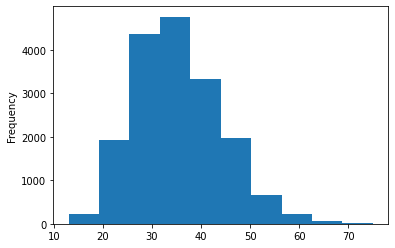

In [ ]:
pd.Series(length_tokenized_headline_pairs).plot.hist()

In [ ]:
print('The max number of characters in any tokenized headline is: ')
pd.Series(length_tokenized_headline_pairs).max()

The max number of characters in any tokenized headline is: 


75

This shows that the tokenizer's max_len parameter can be chosen to be 75

# 11 Single Training and Evaluation of BERT Model

This section is for getting the BERT results. We get BERT, BERT + Additional Preprocessing and BERT + Funlines by rerunning this cell after configuring section 4 appropriately and then running sections 4-10 before this section.

We define the hyperparameters, the BERT model and tokenizer, get the data loaders by using the tokenizer. We finally train and evaluate the model.

In [ ]:
# Hyperparams
EPOCHS = 2
MAX_LEN = 75
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPSILON = 1e-7
SEED = 15
MODEL_NAME = 'bert-base-uncased'
device = get_device_and_set_seed(SEED)

In [ ]:
# Get model and tokenizer
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1).to(device)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

When we were hyperparameter tuning, the train_loader was formed of just 'train.csv' and the valid_loader was fed into the train function. In this final presented state, we train the model on the combined train and validation sets and evaluate the model on the test loader, hence the commented out code from before. 

In [ ]:
# Get Data Loaders
# train_data = Task1Dataset(train_df, tokenizer, max_len=MAX_LEN)
# valid_data = Task1Dataset(valid_df, tokenizer, max_len=MAX_LEN)
# test_data = Task1Dataset(test_df, tokenizer, max_len=MAX_LEN)

# train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
# valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE)
# test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

train_data = Task1Dataset(train_df, tokenizer, max_len=MAX_LEN)
test_data = Task1Dataset(test_df, tokenizer, max_len=MAX_LEN)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [ ]:
train(train_loader, test_loader, model, EPOCHS)

Training model.
| Epoch: 01 | Train Loss/MSE: 0.342 | Train RMSE: 0.584 |                  Val. Loss/MSE: 0.297 | Val. RMSE: 0.545 | Time: 186s
| Epoch: 02 | Train Loss/MSE: 0.257 | Train RMSE: 0.507 |                  Val. Loss/MSE: 0.280 | Val. RMSE: 0.529 | Time: 371s


In [ ]:
# Get final test performance
rmse, _, _ = eval(test_loader, model, print_rmse=True, return_rmse=True)
# save_model(model, rmse)

RMSE: 0.5295


In [ ]:
# Load model if necessary
# model = load_model('model bert-base-uncased 05295')

# 12 Ensembled Running and Evaluation of BERT Model

This section is for training and evaluating the **ensemble** of BERT models. 

We define the hyperparameters (including the number of models we want to ensemble via RERUNS). 

We then train the BERT models, get their predictions on the test set and take the mean of their predictions and evaluate these ensembled predictions.

In [ ]:
# Hyperparams
# RERUNS is the number of BERT Models we want to train
RERUNS = 3
EPOCHS = 2
MAX_LEN = 75
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPSILON = 1e-7
MODEL_NAME = 'bert-base-uncased'
SEED = 10

In [ ]:
# Get test data
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
test_data = Task1Dataset(test_df, tokenizer, max_len=MAX_LEN)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)
rmses = []
all_model_preds = []

# Generate ensembled results
for run in range(RERUNS):
    print('Run #' + str(run))
    # Change seed
    device = get_device_and_set_seed(SEED + run)
    # Get data
    train_data = Task1Dataset(train_df, tokenizer, max_len=MAX_LEN)
    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    # Define model
    model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1).to(device)    
    # Train model
    train(train_loader, test_loader, model, EPOCHS)
    # Evaluate model on test set
    labels = test_df.meanGrade
    rmse, preds, _ = eval(test_loader, model, print_rmse=True, return_rmse=True)
    rmses.append(rmse)   
    all_model_preds.append(preds) 
    # Save model
    # save_model(model, rmse)

mean_preds = np.mean(np.array(all_model_preds), axis=0)
ensemble_rmse = mean_squared_error(test_df.meanGrade, mean_preds, squared=False)
print('Ensemble Test RMSE : {:.4f}'.format(ensemble_rmse))

Run #0


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Training model.
| Epoch: 01 | Train Loss/MSE: 0.342 | Train RMSE: 0.584 |                  Val. Loss/MSE: 0.297 | Val. RMSE: 0.5447 | Time: 183s
| Epoch: 02 | Train Loss/MSE: 0.257 | Train RMSE: 0.507 |                  Val. Loss/MSE: 0.280 | Val. RMSE: 0.5295 | Time: 367s
RMSE: 0.5295
Run #1


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Training model.
| Epoch: 01 | Train Loss/MSE: 0.344 | Train RMSE: 0.587 |                  Val. Loss/MSE: 0.311 | Val. RMSE: 0.5580 | Time: 184s
| Epoch: 02 | Train Loss/MSE: 0.280 | Train RMSE: 0.530 |                  Val. Loss/MSE: 0.289 | Val. RMSE: 0.5374 | Time: 367s
RMSE: 0.5374
Run #2


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Training model.
| Epoch: 01 | Train Loss/MSE: 0.361 | Train RMSE: 0.601 |                  Val. Loss/MSE: 0.342 | Val. RMSE: 0.5848 | Time: 184s
| Epoch: 02 | Train Loss/MSE: 0.307 | Train RMSE: 0.554 |                  Val. Loss/MSE: 0.294 | Val. RMSE: 0.5418 | Time: 367s
RMSE: 0.5418
Ensemble Test RMSE : 0.5260


The ensemble test RMSE reported in Table 1 of the report was slightly lower at 0.5210 than the above cell at 0.5260, so I include the output cell below as proof, it was slightly lower because the third model had a slightly lower RMSE than the one in the cell above. 

In [ ]:
# #  Get preds from models, take mean and then get ensemble RMSE
# #  Add model_names here
# model_names = ['model bert-base-uncased 05295', 'model bert-base-uncased 05361', 'model bert-base-uncased 05342']
# tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
# test_data = Task1Dataset(test_df, tokenizer, max_len=MAX_LEN)
# test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)
# rmses = []
# all_model_preds = []
# for model_name in model_names:
#     model = load_model(model_name)
#     rmse, preds, _ = eval(test_loader, model, return_rmse=True)
#     rmses.append(rmses)
#     all_model_preds.append(preds)

# mean_preds = np.mean(np.array(all_model_preds), axis=0)
# ensemble_rmse = mean_squared_error(test_df.meanGrade, mean_preds, squared=False)
# print('Ensemble Test RMSE : {:.4f}'.format(ensemble_rmse))

Ensemble Test RMSE : 0.5210


# 13 ROBERTA

This section is for training and evaluating the RoBERTa model

We define the hyperparameters, the RoBERTa model and tokenizer, get the data loaders by using the tokenizer. We finally train and evaluate the model. This gave our best model and so it relates to the following sections 14 and 15.

In [ ]:
# Hyperparams
EPOCHS = 2
MAX_LEN = 75
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
EPSILON = 1e-6
SEED = 15
MODEL_NAME = 'roberta-base'
device = get_device_and_set_seed(SEED)

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
train_data = Task1Dataset(train_df, tokenizer, max_len=MAX_LEN)
test_data = Task1Dataset(test_df, tokenizer, max_len=MAX_LEN)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1).to(device)
train(train_loader, test_loader, model, EPOCHS)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Training model.
| Epoch: 01 | Train Loss/MSE: 0.353 | Train RMSE: 0.595 |                  Val. Loss/MSE: 0.272 | Val. RMSE: 0.5215 | Time: 115s
| Epoch: 02 | Train Loss/MSE: 0.267 | Train RMSE: 0.516 |                  Val. Loss/MSE: 0.265 | Val. RMSE: 0.5144 | Time: 230s


In [ ]:
rmse, preds, labels = eval(test_loader, model, print_rmse=True, return_rmse=True)
# save_model(model, rmse)

RMSE: 0.5144


# 14 Codalab Submission

This section is how we got the task-1-roberta.csv in the git repo that contains the best model and we submitted this to Codalab. 

In [ ]:
sub_df = pd.DataFrame(columns=["id", "pred"])
sub_df["id"] = test_df["id"]
sub_df["pred"] = preds
assert len(sub_df) == len(test_df)
sub_df

id      pred
0        36  1.027904
1      2157  0.573284
2      9385  0.506713
3     14434  1.043205
4      9462  0.559342
...     ...       ...
3019   3921  1.093600
3020  12371  0.627824
3021   6845  1.278643
3022   2902  0.761916
3023   4440  1.325291

[3024 rows x 2 columns]

In [ ]:
sub_df.to_csv("task-1-roberta.csv", index=False)

We submitted this RoBERTa model to codalab and ranked 2nd place for task 1, see the image below:

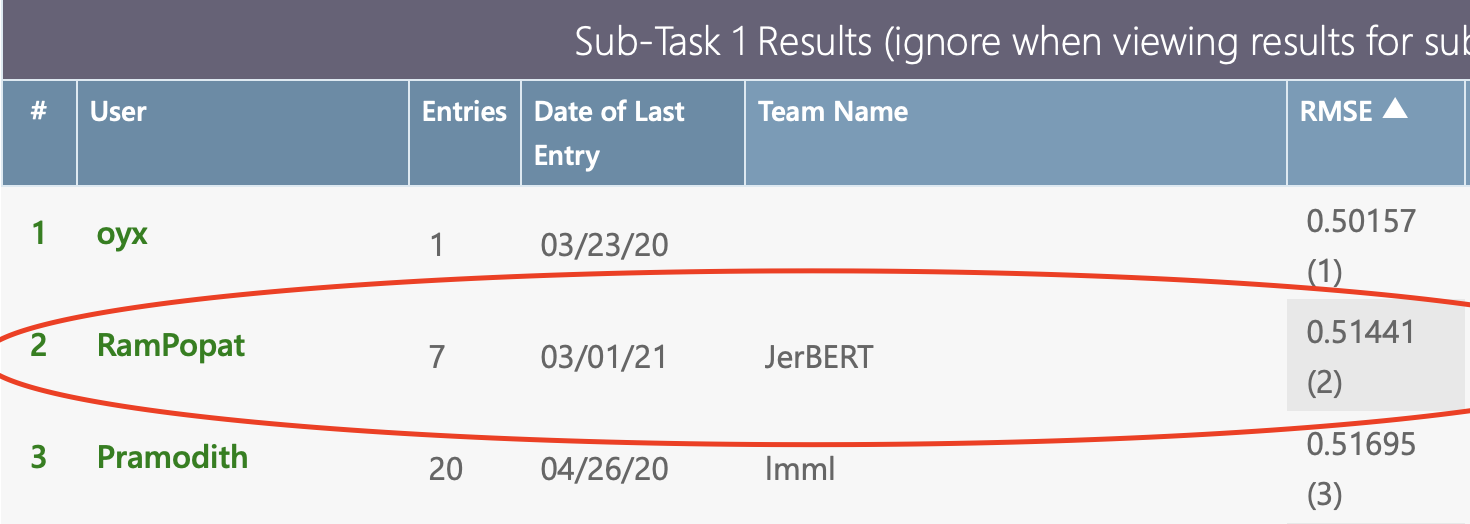

# 15 Visualisation

I loaded my best model when running these cells, but these cells will work if you have been running the notebook sequentially with the output RoBERTa ```model``` (that is likely less good than mine) of section 13.

In [19]:
# def load_model(model_name):
#     path = PATH_TO_SAVED_MODELS + model_name
#     model = RobertaForSequenceClassification.from_pretrained(path).to(device)
#     # model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1).to(device)
#     # model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

In [21]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 75
BATCH_SIZE = 32
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)
test_data = Task1Dataset(test_df, tokenizer, max_len=MAX_LEN)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [22]:
# model = load_model(model_name='model roberta-base 05144')

rmse, preds, labels = eval(test_loader, model, print_rmse=True, return_rmse=True)

RMSE: 0.5144


## 15.1 Predictive Distribution

We compute min, max, mean of both the test dataset and compare with the RoBERTa model's predictions. The other notebook has a special overlay plot for this.

In [23]:
min(preds), max(preds), preds.mean()

(0.287164, 1.9148906, 0.9227176)

In [24]:
min(labels), max(labels), labels.mean()

(0.0, 2.8, 0.93958336)

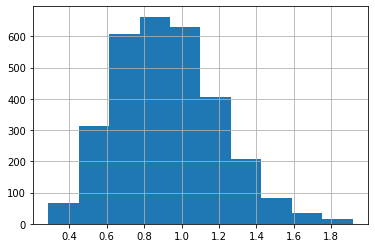

In [25]:
pd.Series(preds).hist()

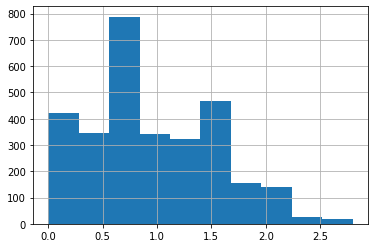

In [26]:
pd.Series(labels).hist()

Next, we compute the true vs predicted humour grade for the Roberta Model.

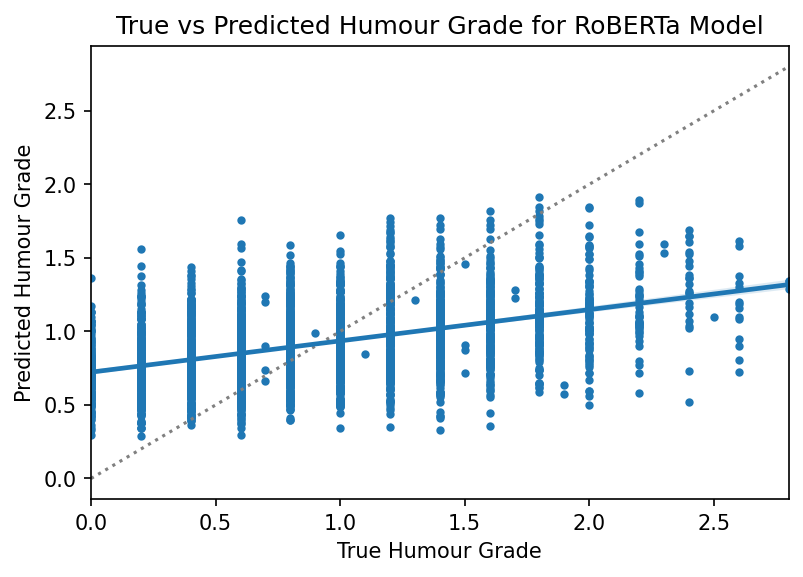

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
def get_pred_true_plot(preds, labels, title):
    limits = [labels.min(), labels.max()]
    fig, ax = plt.subplots()
    fig.set_dpi(150)
    ax.set_title(title)
    ax.scatter(labels, preds, marker='.')
    ax.plot(limits, limits, color="gray", linestyle=":")
    ax.set_xlabel('True Humour Grade')
    ax.set_ylabel('Predicted Humour Grade')
    sns.regplot(x=labels, y=preds, ax=ax, scatter_kws={"s": 5})
    plt.show()

get_pred_true_plot(preds, labels, 'True vs Predicted Humour Grade for RoBERTa Model')

## 15.2 RoBERTa Visualisation

In this section we ascertain which are the best predictions, we get the corresponding tokens and attention by passing in the appropriate dataset ID and then we use the bert-viz visualiser to analyse what the model's CLS token is paying attention to. This was described in the report. 

IDs of Headlines sorted by their corresponding Mean Absolute Error of the predicted humour grade with respect to the true humour grade. This is so that we can choose the best predictions using their IDs to visualise them using the BERT/RoBERTa visualiser in the subsequent cells

In [35]:
mae_df = pd.DataFrame(np.array([abs(preds - labels)]).T, columns=['MAE of Preds vs Labels']).sort_values('MAE of Preds vs Labels')
mae_df.head(15)

MAE of Preds vs Labels
2552                0.000201
1298                0.000687
1728                0.001022
467                 0.001256
922                 0.001363
827                 0.001431
422                 0.001607
229                 0.001986
390                 0.002527
1262                0.002741
2367                0.003002
2715                0.003377
2083                0.003465
650                 0.003621
33                  0.003951

In [33]:
def get_tokens_attention_for_id(headline_id=None):
    if headline_id is None:
        headline_id = abs(labels - preds).idxmin()   

    # Get the headline pair
    test_df['original'][headline_id]
    test_df['edit'][headline_id]
    headline_orig, headline_edit = Task1Dataset.get_headline_pair(test_df['original'][headline_id], test_df['edit'][headline_id])

    # Tokenize the headline pair
    tokenize_dict = tokenizer(text=headline_orig, text_pair=headline_edit, add_special_tokens=True,
                                                                    return_tensors='pt', return_token_type_ids=True, return_attention_mask=True)

    # Feed this tokenized headline pair into the model 
    input_ids, token_type_ids, attention_mask = tokenize_dict['input_ids'], tokenize_dict['token_type_ids'], \
                                                                                                    tokenize_dict['attention_mask']
    input_ids, token_type_ids, attention_mask = (
        input_ids.to(device),
        token_type_ids.to(device),
        attention_mask.to(device),
    )
    label = torch.tensor(test_df['meanGrade'][headline_id]).to(device)

    outputs = model.forward(
    input_ids=input_ids,
    labels=label,
    attention_mask=attention_mask,
    token_type_ids=token_type_ids,
    output_attentions=True
    )

    # Get the output attentions and tokenizer's output tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids.detach().cpu().numpy().squeeze())
    attention = outputs.attentions
    return tokens, attention

# We choose one of the good predictions from the cell above with id 1298
tokens, attention = get_tokens_attention_for_id(1298)

**Head View**
The attention-head view visualizes attention in one or more heads in a particular layer in the model.

For example, for the RoBERTa model on the best predictions (i.e. with least error), we found that it pays attention to the edit word in the last layer, e.g. see the image in the screenshot in the cell below, where I have highlighted the original and edit word. However, you can actually try the interactive visualiser in the cell afterwards.

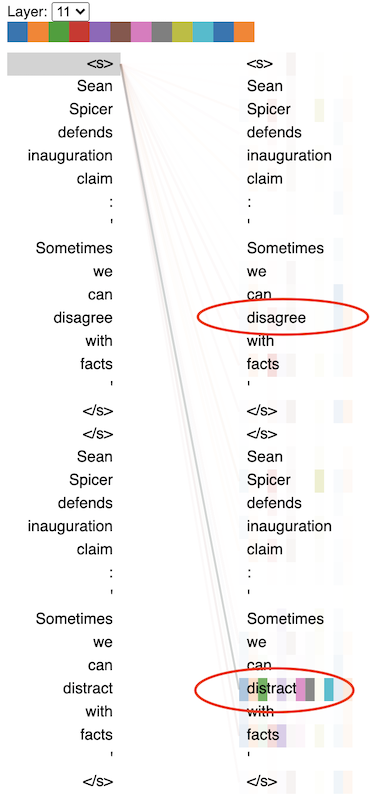

**Usage**
* **Hover** over any **token** on the left/right side of the visualization to filter attention from/to that token. The colors correspond to different attention heads.
* **Double-click** on any of the **colored tiles** at the top to filter to the corresponding attention head.
* **Single-click** on any of the **colored tiles** to toggle selection of the corresponding attention head. 
* **Click** on the **Layer** drop-down to change the model layer (zero-indexed).
* The lines show the attention from each token (left) to every other token (right). Darker lines indicate higher attention weights. When multiple heads are selected, the attention weights are overlaid on one another. 

Try the interactive visualiser below

In [34]:
head_view(attention, tokens)

<IPython.core.display.Javascript object>

# 16 ALBERT

This section is for training and evaluating the ALBERT model

We define the hyperparameters, the ALBERT model and tokenizer, get the data loaders by using the tokenizer. We finally train and evaluate the model.

In [ ]:
# Hyperparams
EPOCHS = 2
MAX_LEN = 75
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPSILON = 1e-7
SEED = 15
MODEL_NAME = 'albert-base-v2'
device = get_device_and_set_seed(SEED)

In [ ]:
tokenizer = AlbertTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
train_data = Task1Dataset(train_df, tokenizer, max_len=MAX_LEN)
test_data = Task1Dataset(test_df, tokenizer, max_len=MAX_LEN)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [ ]:
model = AlbertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1).to(device)
train(train_loader, test_loader, model, EPOCHS)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

Training model.
| Epoch: 01 | Train Loss/MSE: 0.383 | Train RMSE: 0.619 |                  Val. Loss/MSE: 0.330 | Val. RMSE: 0.5747 | Time: 119s
| Epoch: 02 | Train Loss/MSE: 0.354 | Train RMSE: 0.595 |                  Val. Loss/MSE: 0.330 | Val. RMSE: 0.5747 | Time: 237s


In [ ]:
rmse, _, _ = eval(test_loader, model, print_rmse=True, return_rmse=True)

RMSE: 0.5747


In [ ]:
# save_model(model, rmse)